In [21]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage
import os
import cv2
from tqdm import tqdm
import utils

In [3]:
vol_img = sitk.ReadImage(r"C:\Users\Audit\Uppsala - Masters Europe\Semester 3\Project in Image analysis - Software\UCAN-PET-CT-image-data-handling-pipeline\Task 2.1\Data\sample3Dimg.nrrd")

# file_reader = sitk.ImageFileReader()
# file_reader.SetImageIO('NrrdImageIO')
# file_reader.SetFileName(r"C:\Users\Audit\Uppsala - Masters Europe\Semester 3\Project in Image analysis - Software\UCAN-PET-CT-image-data-handling-pipeline\Task 2.1\Data\sample3Dimg.nrrd")
# file_reader.Execute()

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\1\sitk\Code\IO\src\sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "C:\Users\Audit\Uppsala - Masters Europe\Semester 3\Project in Image analysis - Software\UCAN-PET-CT-image-data-handling-pipeline\Task 2.1\Data\sample3Dimg.nrrd" does not exist.

(-0.5, 167.5, 167.5, -0.5)

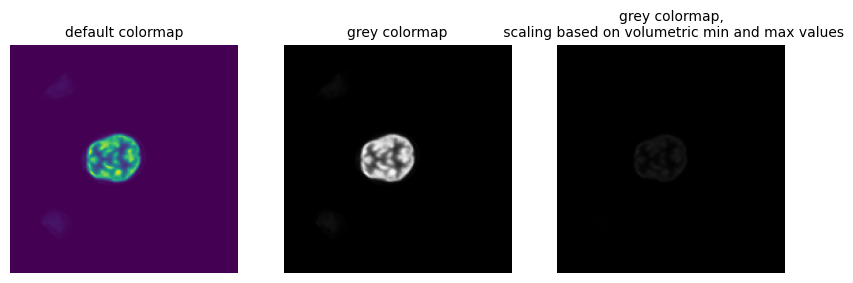

In [136]:
# Display the image slice from the middle of the stack, z axis
# print(vol_img.GetDepth())
z = int(vol_img.GetDepth()/10)
npa_zslice = sitk.GetArrayViewFromImage(vol_img)[z,:,:]
npa = sitk.GetArrayViewFromImage(vol_img)
# Three plots displaying the same data, how do we deal with the high dynamic range?
fig = plt.figure(figsize=(10,3))

fig.add_subplot(1,3,1)
plt.imshow(npa_zslice)
plt.title('default colormap', fontsize=10)
plt.axis('off')

fig.add_subplot(1,3,2)
plt.imshow(npa_zslice,cmap=plt.cm.Greys_r)
plt.title('grey colormap', fontsize=10)
plt.axis('off')

fig.add_subplot(1,3,3)
plt.title('grey colormap,\n scaling based on volumetric min and max values', fontsize=10)
plt.imshow(npa_zslice,cmap=plt.cm.Greys_r, vmin=npa.min(), vmax=npa.max())
plt.axis('off')

In [4]:
#stik [x,y,z]-> numpy [z,x,y]
nda = sitk.GetArrayFromImage(vol_img)
print(vol_img.GetSize())
print(nda.shape)

nda2d=sitk.GetArrayFromImage(vol_img[:,:,0])
print(nda2d)

(168, 168, 553)
(553, 168, 168)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
# numpy array  -> stik

nda_as_image = sitk.GetImageFromArray(nda)
print(nda_as_image.GetSize())

(168, 168, 553)


In [6]:
# voxel queries

print(vol_img.GetPixelIDValue())
print(vol_img.GetPixelIDTypeAsString())
print(vol_img.GetNumberOfComponentsPerPixel())

9
64-bit float
1


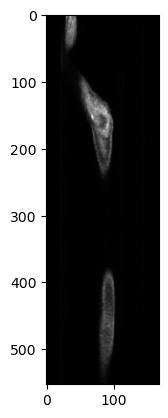

In [7]:
# Accessing and slicing
#help(vol_img.GetPixel)

#slice voxel first

# row z wise slice
# slice_2d=vol_img[:,:,50]
# plt.imshow(sitk.GetArrayFromImage(slice_2d),cmap='gray')

# row x wise slice
# slice_2d=vol_img[96,:,:]
# print(type(slice_2d))
# plt.imshow(np.add(sitk.GetArrayFromImage(slice_2d)),cmap='gray')

# row y wise slice
slice_2d=vol_img[:,40,:]
plt.imshow(sitk.GetArrayFromImage(slice_2d),cmap='gray')


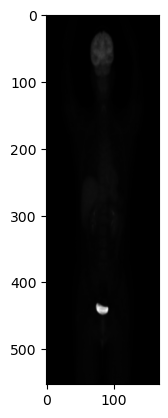

In [8]:
#display img averaged over all pixels

mean_img=np.zeros(nda_as_image.GetSize()[0:1])
for i in range (nda_as_image.GetSize()[0]):
   mean_img=mean_img+sitk.GetArrayFromImage(vol_img[i,:,:])
mean_img=mean_img/nda_as_image.GetSize()[0]
#mean_img=mean_img+50*np.ones(nda_as_image.GetSize()[0:1])
plt.imshow(mean_img,cmap='gray')

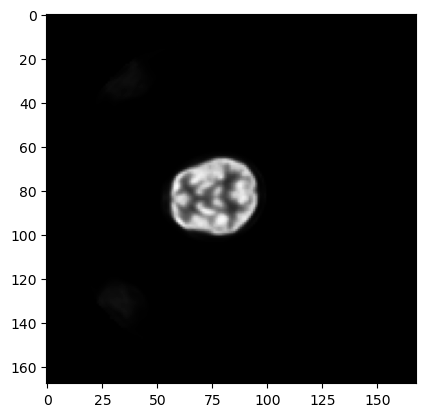

In [130]:
#slice angle
plt.imshow(npa_zslice,cmap=plt.cm.Greys_r)

#type of projecttion - min/max

In [191]:
def make_isotropic(image, interpolator = sitk.sitkLinear):
    '''
    Resample an image to isotropic pixels (using smallest spacing from original) and save to file. Many file formats 
    (jpg, png,...) expect the pixels to be isotropic. By default the function uses a linear interpolator. For
    label images one should use the sitkNearestNeighbor interpolator so as not to introduce non-existant labels.
    '''
    original_spacing = image.GetSpacing()
    # Image is already isotropic, just return a copy.
    if all(spc == original_spacing[0] for spc in original_spacing):
        return sitk.Image(image)
    # Make image isotropic via resampling.
    original_size = image.GetSize()
    min_spacing = min(original_spacing)
    new_spacing = [min_spacing]*image.GetDimension()
    new_size = [int(round(osz*ospc/min_spacing)) for osz,ospc in zip(original_size, original_spacing)]
    return sitk.Resample(image, new_size, sitk.Transform(), interpolator,
                         image.GetOrigin(), new_spacing, image.GetDirection(), 0,
                         image.GetPixelID())

def save_projections(image,img_name,max_intensity=50,min_intensity=-1024):
    writer = sitk.ImageFileWriter()
    img=sitk.Extract(image, image.GetSize())
    writer.SetFileName(img_name)

    #img=make_isotropic(img)

    img_write=sitk.Cast(
        sitk.IntensityWindowing(
            img, windowMinimum=min_intensity, windowMaximum=max_intensity, outputMinimum=100.0, outputMaximum=255.0
        ),
        sitk.sitkUInt8,
    )

    writer.Execute(img_write)  #sitk.Cast(sitk.RescaleIntensity(img,outputMinimum=0,outputMaximum=15)

In [192]:
projection = {'sum': sitk.SumProjection,
              'mean':  sitk.MeanProjection,
              'std': sitk.StandardDeviationProjection,
              'min': sitk.MinimumProjection,
              'max': sitk.MaximumProjection}
ptype = 'max'
paxis = 0

rotation_axis = [0,0,1]
rotation_angles = np.linspace(-1/2*np.pi, 1/2*np.pi, int(180.0/15.0)) #15 degree 
rotation_center = vol_img.TransformContinuousIndexToPhysicalPoint([(index-1)/2.0 for index in vol_img.GetSize()])

rotation_transform = sitk.VersorRigid3DTransform()
rotation_transform.SetCenter(rotation_center)

#Compute bounding box of rotating volume and the resampling grid structure
image_indexes = list(zip([0,0,0], [sz-1 for sz in vol_img.GetSize()]))
image_bounds = []
for i in image_indexes[0]:
    for j in image_indexes[1]:
        for k in image_indexes[2]:
            image_bounds.append(vol_img.TransformIndexToPhysicalPoint([i,j,k]))

all_points = []
for angle in rotation_angles:
    rotation_transform.SetRotation(rotation_axis, angle)    
    all_points.extend([rotation_transform.TransformPoint(pnt) for pnt in image_bounds])
    
all_points = np.array(all_points)
min_bounds = all_points.min(0)
max_bounds = all_points.max(0)

#resampling grid will be isotropic so no matter which direction we project to
#the images we save will always be isotropic (required for vol_img formats that 
#assume isotropy - jpg,png,tiff...)

new_spc = [np.min(vol_img.GetSpacing())]*3
new_sz = [int(sz/spc + 0.5) for spc,sz in zip(new_spc, max_bounds-min_bounds)]

pix_array=sitk.GetArrayFromImage(vol_img)
maxtensity,mintensity=pix_array.max(),pix_array.min()

proj_images = []
i=0
for angle in rotation_angles:
    rotation_transform.SetRotation(rotation_axis, angle) 
    resampled_image = sitk.Resample(image1=vol_img,
                                    size=new_sz,
                                    transform=rotation_transform,
                                    interpolator=sitk.sitkLinear,
                                    outputOrigin=min_bounds,
                                    outputSpacing=new_spc,
                                    outputDirection = [1,0,0,0,1,0,0,0,1],
                                    defaultPixelValue =  -20, #HU unit for air in CT, possibly set to 0 in other cases
                                    outputPixelType = vol_img.GetPixelID())
    proj_image = projection[ptype](resampled_image, paxis)
    extract_size = list(proj_image.GetSize())
    extract_size[paxis]=0
    proj_images.append(sitk.Extract(proj_image, extract_size))

    img_n=r'C:\Users\Audit\Uppsala - Masters Europe\Semester 3\Project in Image analysis - Software\UCAN-PET-CT-image-data-handling-pipeline\Task 2.1\Data\Sample 2D projections\sample_{0}.png'.format(i)
    save_projections(sitk.InvertIntensity(sitk.Extract(proj_image, extract_size),maximum=1),img_name=img_n)
    print(i,angle,mintensity)
    i+=1


# Stack all images into fuax-volume for display
#sitk.Show(sitk.JoinSeries(proj_images))



0 -1.5707963267948966 0.0
1 -1.2851969946503699 0.0
2 -0.9995976625058433 0.0
3 -0.7139983303613167 0.0
4 -0.42839899821678995 0.0
5 -0.14279966607226324 0.0
6 0.14279966607226324 0.0
7 0.42839899821678995 0.0
8 0.7139983303613167 0.0
9 0.9995976625058431 0.0
10 1.28519699465037 0.0
11 1.5707963267948966 0.0


In [184]:
print(pix_array.min())

0.0


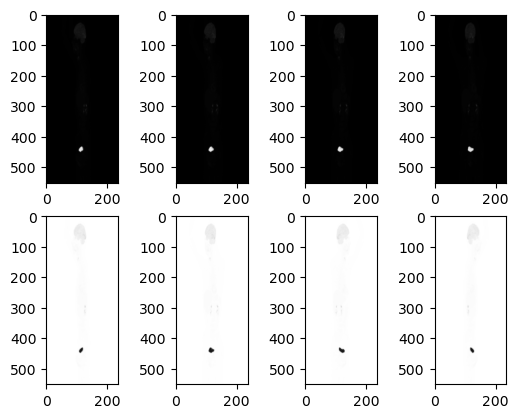

In [134]:
#proj_image[0,:,:].GetSize()

inv_imgs=[]
for i in [0,3,9,11]:
    ext=sitk.Extract(proj_images[i], proj_images[i].GetSize())
    inv_ext=sitk.InvertIntensity(ext,maximum=1)
    
    inv_imgs.append(inv_ext)
    
#plt.imshow(sitk.GetArrayFromImage(proj_images[0]),cmap='gray')

intensity_clipper=sitk.IntensityWindowingImageFilter

for i in range(1,5):
    plt.subplot(2,4,i)
    intensity_clipper().SetOutputMaximum(15)
    intensity_clipper().SetOutputMinimum(0)
    plt.imshow(sitk.GetArrayFromImage(proj_images[i]),cmap='gray')

for i in range(1,5):
    plt.subplot(2,4,i+4)
    plt.imshow(sitk.GetArrayFromImage(inv_imgs[i-1]),cmap='gray')

In [37]:
def generate_MIPs(SUV, rot_min=-90, rot_max=90, rot_interval=15 ):
    """
    Generate rotating 2D MIPs along coronal direction from (-90, 90).
    """
    imgs=[]
    SUV = np.transpose(SUV, (2,1,0))
    for i in tqdm(range(rot_min, rot_max+1, rot_interval)):
            print("angle: ", i)
            suv_temp = scipy.ndimage.rotate(SUV, angle=i, axes=(0,1))
            suv_temp = np.clip(suv_temp, 0, 15)
            suv_MIP = np.max(suv_temp, axis=1).astype("float")
            
            suv_MIP = suv_MIP/np.max(suv_MIP)
            suv_MIP = np.absolute(suv_MIP - np.amax(suv_MIP))
            suv_MIP = cv2.rotate(suv_MIP, cv2.ROTATE_90_COUNTERCLOCKWISE)

            suv_MIP = suv_MIP[:,60:-60]
            imgs.append(suv_MIP)
    return imgs
suv_imgs=generate_MIPs(sitk.GetArrayFromImage(vol_img))

  0%|          | 0/13 [00:00<?, ?it/s]

angle:  -90


  8%|▊         | 1/13 [00:04<00:51,  4.28s/it]

angle:  -75


 15%|█▌        | 2/13 [00:09<00:53,  4.85s/it]

angle:  -60


 23%|██▎       | 3/13 [00:14<00:50,  5.08s/it]

angle:  -45


 31%|███       | 4/13 [00:20<00:47,  5.22s/it]

angle:  -30


 38%|███▊      | 5/13 [00:25<00:42,  5.26s/it]

angle:  -15


 46%|████▌     | 6/13 [00:30<00:35,  5.02s/it]

angle:  0


 54%|█████▍    | 7/13 [00:34<00:28,  4.70s/it]

angle:  15


 62%|██████▏   | 8/13 [00:38<00:23,  4.67s/it]

angle:  30


 69%|██████▉   | 9/13 [00:43<00:19,  4.80s/it]

angle:  45


 77%|███████▋  | 10/13 [00:49<00:14,  4.89s/it]

angle:  60


 85%|████████▍ | 11/13 [00:54<00:10,  5.07s/it]

angle:  75


 92%|█████████▏| 12/13 [00:59<00:05,  5.05s/it]

angle:  90


100%|██████████| 13/13 [01:03<00:00,  4.91s/it]


13


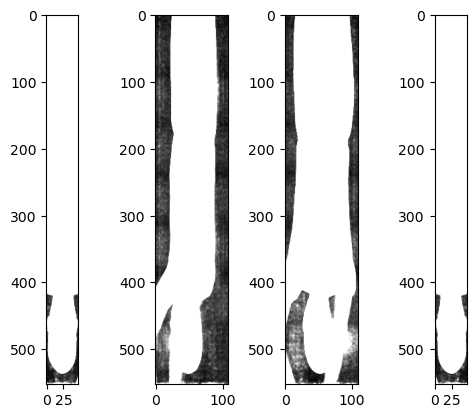

In [43]:
inv_suv_imgs=[]
for i in [0,4,10,12]:
    ext=sitk.Extract(sitk.GetImageFromArray(suv_imgs[i]), sitk.GetImageFromArray(suv_imgs[i]).GetSize())
    inv_ext=sitk.InvertIntensity(ext,maximum=150)
    inv_suv_imgs.append(inv_ext)
    #plt.imshow(sitk.GetImageFromArray(proj_image[0,:,:]),cmap='gray')
print(len(suv_imgs))
for i,j in zip([0,4,10,12],[1,2,3,4]):
    plt.subplot(1,4,j)
    plt.imshow(sitk.GetArrayFromImage(inv_suv_imgs[j-1]),cmap='gray')
    #plt.imshow(suv_imgs[i],cmap='gray')

In [4]:
skele=sitk.GetArrayFromImage(vol_img)
skele=skele[skele<200]

#adipose=vol_img[100<vol_img & 500>vol_img]

In [16]:
skele.shape

(15322498,)

In [13]:
image_viewer = sitk.ImageViewer()
sk=sitk.Extract(sitk.GetImageFromArray(skele), sitk.GetImageFromArray(vol_img).GetSize())
image_viewer.SetTitle('grid using ImageViewer class')
image_viewer.Execute(sk)

RuntimeError: Exception thrown in SimpleITK new_Image: D:\a\1\sitk\Code\Common\src\sitkImageExplicit.cxx:102:
sitk::ERROR: Unsupported number of dimensions specified by size: [ 15322498 ]!
The maximum supported Image dimension is 5.

In [5]:
#read master data
master_data = pd.read_csv('F:/U-CAN-Lymfom_A/Selected_for_UCAN_project/Selected_exams_from_U-CAN-Lymfom_A_MasterDataset.csv')

master_data.head(1)

,directory,root_directory,source_directory,patient_info,patient_directory,PET-CT_info,dicom_img,patient_id,patient_age,patient_weight,...,recons_method,image_type,aquisition_dt,study_desc,series_desc,protocol,corr_img,modality,manufacturer,manufacturer_model
0,F:\U-CAN-Lymfom_A\Raw_DCM_transf_date_20221205...,U-CAN-Lymfom_A,Raw_DCM_transf_date_20221205__06__n86_90GB,ASPTCTX0001_npr134758508773-20191212\CT-201912...,ASPTCTX0001_npr134758508773-20191212,CT-20191212-112330-3.7-WB_FDG-CT-VENFAS-WB-Ven...,1.2.840.113619.2.5.42235195.12863.1576135318.405,npr134758508773,74.0,'72.0',...,NaN,"['DERIVED', 'SECONDARY', 'REFORMATTED', 'AVER...",'20191212','PET FDG WB 1 h','WB Venfas 3 ax','3.7 WB_FDG CT VENFAS',NaN,'CT','GE MEDICAL SYSTEMS','Discovery MI'


In [22]:
exception_lst = []
for index, row in master_data.iterrows():

    #vol_img = sitk.ReadImage(row['directory'])
    
    print(row['directory'])

    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(row['directory'])
    reader.SetFileNames(dicom_names)
    vol_img = reader.Execute()

    name_suffix = r'F:\U-CAN-Lymfom_A\Selected_for_UCAN_project\Selected_CTMean&PETMax_Projections\\' + \
                  str(row['patient_directory']) + str(row['modality'])
    if row['modality']=="PT":
        ptype = 'max'
    else:
        ptype = 'mean'
    
    angle = 90.0
    
    try:
        utils.get_2D_projections(vol_img,ptype,angle,save_img=True,img_n=name_suffix)
    except:
        exception_lst.append(row['directory'])
    
    if index>10:
        break


F:\U-CAN-Lymfom_A\Raw_DCM_transf_date_20221205__06__n86_90GB\ASPTCTX0001_npr134758508773-20191212\CT-20191212-112330-3.7-WB_FDG-CT-VENFAS-WB-Venfas-3-ax-3.000000mm_JK_
F:\U-CAN-Lymfom_A\Raw_DCM_transf_date_20221205__06__n86_90GB\ASPTCTX0001_npr134758508773-20191212\PT-20191212-110507-3.7-WB_FDG-CT-VENFAS-QCFX-S-400-2.7900mm_JK_
F:\U-CAN-Lymfom_A\Raw_DCM_transf_date_20221205__06__n86_90GB\ASPTCTX0001_npr190483255078-20210203\CT-20210203-104152-3.12-WB_FDG-VENFAS--THORAX-INANDAD-WB-Venfas-3-ax-3.000000mm_JK_
F:\U-CAN-Lymfom_A\Raw_DCM_transf_date_20221205__06__n86_90GB\ASPTCTX0001_npr190483255078-20210203\PT-20210203-102515-3.12-WB_FDG-VENFAS--THORAX-INANDAD-QCFX-S-400-M.Free-2.8000mm_JK_
F:\U-CAN-Lymfom_A\Raw_DCM_transf_date_20221205__06__n86_90GB\ASPTCTX0001_npr247990973381-20220628\CT-20220628-150520-3.12-WB-F18-FDG-VENFAS--THORAX-INANDAD-XL-WB-Venfas-3-ax-3.000000mm_JK_
F:\U-CAN-Lymfom_A\Raw_DCM_transf_date_20221205__06__n86_90GB\ASPTCTX0001_npr247990973381-20220628\PT-20220628-145303

In [ ]:
with open(r'F:\U-CAN-Lymfom_A\Selected_for_UCAN_project\Selected_CTMean&PETMax_Projections\exception_lst.txt', 'w') as fp:
    for item in exception_lst:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


In [16]:
print(master_data['modality'][0])
#master_data['modality'][0].strip()=="'CT'"


CT


In [15]:
master_data['modality'] = master_data['modality'].apply(lambda x: x.strip().replace("'",""))